<a href="https://colab.research.google.com/github/xzj2004/ailearn/blob/main/notebooks/train-yolov12-200pad-object-detection-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train YOLOv12 Object Detection on a Custom Dataset

---

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov12-object-detection-model.ipynb)
[![arXiv](https://img.shields.io/badge/arXiv-2502.12524-b31b1b.svg)](https://arxiv.org/abs/2502.12524)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/train-yolov12-model)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/sunsmarterjie/yolov12)

[YOLOv12](https://github.com/sunsmarterjie/yolov12) is a newly proposed attention-centric variant of the YOLO family that focuses on incorporating efficient attention mechanisms into the backbone while preserving real-time performance. Instead of relying heavily on CNN-based architectures like its predecessors, YOLOv12 introduces a simple yet powerful “area attention” module, which strategically partitions the feature map to reduce the quadratic complexity of full self-attention. It also adopts residual efficient layer aggregation networks (R-ELAN) to enhance feature aggregation and training stability, especially for larger models. These innovations, together with refinements such as scaled residual connections and a reduced MLP ratio, enable YOLOv12 to harness the benefits of attention (e.g., better global context modeling) without sacrificing speed.

![yolov12-area-attention](https://media.roboflow.com/notebooks/examples/yolov12-area-attention.png)

Compared to prior YOLO iterations (e.g., YOLOv10, YOLOv11, and YOLOv8), YOLOv12 achieves higher detection accuracy with competitive or faster inference times across all model scales. Its five sizes—N, S, M, L, and X—range from 2.6M to 59.1M parameters, striking a strong accuracy–speed balance. For instance, the smallest YOLOv12-N surpasses other “nano” models by over 1% mAP with latency around 1.6 ms on a T4 GPU, and the largest YOLOv12-X achieves 55.2% mAP, comfortably outscoring comparable real-time detectors such as RT-DETR and YOLOv11-X . By matching or exceeding state-of-the-art accuracy while remaining fast, YOLOv12 represents a notable step forward for attention-based real-time object detection.

![yolov12-metrics](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/yolov12-metrics.png)

## Environment setup

### Configure your API keys

To fine-tune YOLOv12, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [1]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [2]:
!nvidia-smi

Sun Jun 29 03:27:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [4]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 68.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 122.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

In [ ]:
!wget https://media.roboflow.com/notebooks/examples/dog.jpeg

--2025-06-26 06:10:46--  https://media.roboflow.com/notebooks/examples/dog.jpeg
Resolving media.roboflow.com (media.roboflow.com)... 34.110.133.209
Connecting to media.roboflow.com (media.roboflow.com)|34.110.133.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106055 (104K) [image/jpeg]
Saving to: ‘dog.jpeg’

dog.jpeg            100%[===================>] 103.57K  --.-KB/s    in 0.001s  

2025-06-26 06:10:46 (104 MB/s) - ‘dog.jpeg’ saved [106055/106055]



## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

100%|██████████| 51.4M/51.4M [00:02<00:00, 26.9MB/s]


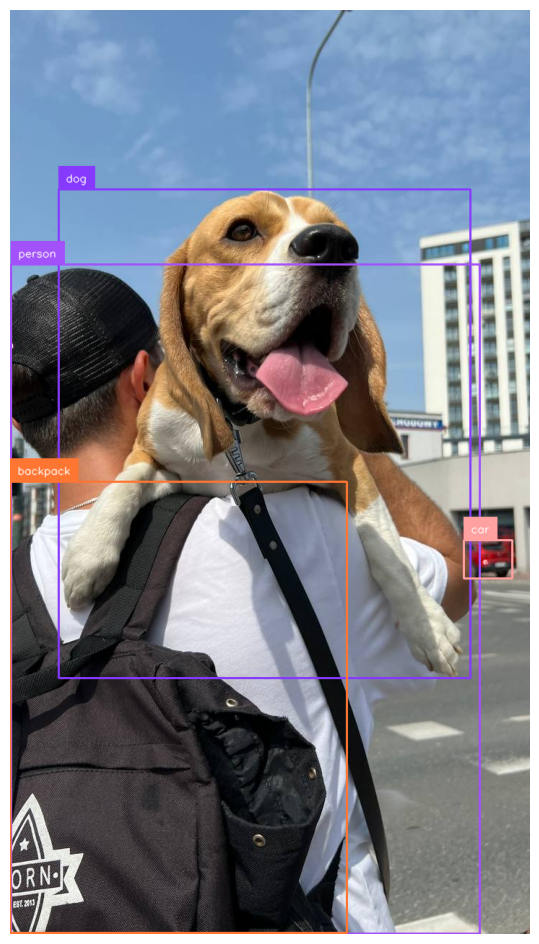

In [ ]:
import cv2
from ultralytics import YOLO
import supervision as sv


image_path = f"{HOME}/dog.jpeg"
image = cv2.imread(image_path)

model = YOLO('yolov12l.pt')

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

## Download dataset from Roboflow Universe

In [5]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="nSggBt2ylNioyiIFoaWI")
project = rf.workspace("wr666").project("hanpanzong")
version = project.version(2)
dataset = version.download("yolov12")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to hanpanzong-2 in yolov12:: 100%|██████████| 128/128 [00:00<00:00, 5394.44it/s]


In [ ]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [6]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [7]:
!cat {dataset.location}/data.yaml

train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['pad']

roboflow:
  workspace: wr666
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [9]:
from ultralytics import YOLO

model = YOLO('yolov12n-seg.pt')

results = model.train(data=f'{dataset.location}/data.yaml', batch=16, epochs=200)

New https://pypi.org/project/ultralytics/8.3.160 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=segment, mode=train, model=yolov12n-seg.pt, data=/content/hanpanzong-2/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

100%|██████████| 755k/755k [00:00<00:00, 31.7MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      2368  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2, 1, 2]          
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2, 1, 4]          
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  2    174720  ultralytics.nn.modules.block.A2C2f           [128, 128, 2, True, 4]        
  7                  -1  1    295424  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 131MB/s]


AMP: checks passed ✅


train: Scanning /content/hanpanzong-2/train/labels... 54 images, 0 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<00:00, 729.28it/s]

train: New cache created: /content/hanpanzong-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /content/hanpanzong-2/valid/labels... 3 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3/3 [00:00<00:00, 185.31it/s]

val: New cache created: /content/hanpanzong-2/valid/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 130 weight(decay=0.0), 141 weight(decay=0.0005), 140 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/segment/train
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/200      5.07G      2.379      3.363      3.557      1.479        257        640: 100%|██████████| 4/4 [00:09<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.22it/s]

                   all          3        125    0.00111      0.008   0.000591   0.000118    0.00222      0.016    0.00117   0.000289



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/200      5.86G      2.115      3.359      3.529      1.358        315        640: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all          3        125    0.00444      0.032    0.00238   0.000578    0.00556       0.04    0.00303    0.00152



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/200      5.08G      1.286      1.838      3.171     0.9359        355        640: 100%|██████████| 4/4 [00:04<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all          3        125     0.0522      0.376     0.0503     0.0222     0.0667       0.48     0.0636     0.0314



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/200      4.99G      1.086      1.391      2.634     0.8665        200        640: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all          3        125     0.0856      0.616     0.0951     0.0437     0.0922      0.664      0.102     0.0639



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/200      5.53G       1.15      1.307      2.368     0.8532        293        640: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all          3        125     0.0956      0.688      0.108     0.0495     0.0989      0.712      0.109     0.0655



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/200      5.39G      1.253      1.238      2.212     0.8474        274        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.58it/s]

                   all          3        125      0.101      0.728      0.122      0.057     0.0944       0.68       0.11     0.0669



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/200       5.6G      1.088      1.112      1.867     0.8361        221        640: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all          3        125      0.104      0.752      0.142     0.0644     0.0944       0.68      0.124     0.0816



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/200      4.97G      1.094      1.159      1.634     0.8345        219        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all          3        125      0.103      0.744      0.144     0.0631      0.104      0.752      0.135     0.0812



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/200      5.46G      1.078      1.084      1.423     0.8388        168        640: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all          3        125      0.106       0.76      0.235      0.132     0.0978      0.704      0.178      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/200      5.41G      1.074      1.218      1.248     0.8353        244        640: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all          3        125      0.106       0.76       0.38      0.186      0.111        0.8      0.365       0.22



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/200      5.12G      1.089      1.173      1.213      0.839        470        640: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]

                   all          3        125      0.108      0.776      0.607      0.278      0.103      0.744      0.473      0.292



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/200      5.63G      1.011      1.129     0.9703     0.8317        304        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all          3        125      0.109      0.784      0.742      0.325      0.112      0.808      0.621       0.37



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/200      5.39G     0.9964      1.077     0.8666     0.8251        470        640: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.24it/s]

                   all          3        125      0.107      0.768      0.717      0.354      0.109      0.784      0.637      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/200      4.93G     0.8907      1.011       0.74     0.8312        294        640: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all          3        125      0.119      0.856      0.696      0.369      0.116      0.832      0.614      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/200      5.32G     0.8713     0.9641     0.7087     0.8199        283        640: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all          3        125      0.138      0.992      0.742      0.425      0.117       0.84      0.552      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/200       5.3G     0.9631      1.076     0.7432     0.8276        428        640: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all          3        125      0.139          1      0.837      0.509      0.121      0.872      0.632      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/200      5.45G      0.856      1.001     0.6897      0.829        372        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all          3        125      0.933      0.777      0.901       0.53      0.876       0.51      0.693      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/200       5.8G     0.8565     0.9764     0.6865     0.8363        184        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all          3        125          1       0.49      0.967      0.634      0.963      0.417      0.769      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/200      5.48G     0.8404     0.9565     0.6687     0.8308        274        640: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all          3        125      0.985      0.512      0.956       0.57      0.943      0.488      0.796      0.513



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/200      5.14G     0.8459     0.9253     0.6605     0.8257        397        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all          3        125      0.972      0.564      0.941      0.592      0.931       0.54      0.777      0.485



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.94G     0.8961     0.9497     0.6582     0.8274        292        640: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all          3        125      0.987      0.622      0.947      0.586      0.898      0.566      0.777      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/200      5.06G     0.8702     0.9472     0.6766     0.8416        297        640: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all          3        125      0.976      0.659      0.946      0.509      0.988      0.643      0.857      0.546



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/200      4.92G     0.9247     0.9501     0.6734     0.8432        326        640: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all          3        125      0.966      0.676      0.951      0.575      0.952      0.628      0.838      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/200      5.27G     0.8043     0.9226     0.6333     0.8305        279        640: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          3        125      0.952      0.728       0.96      0.633      0.835      0.608      0.769      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.97G     0.8977     0.8431      0.636     0.8343        225        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all          3        125      0.891      0.854      0.959      0.611      0.733      0.728      0.775      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/200      5.19G      0.856     0.9226     0.6357      0.828        350        640: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all          3        125      0.889      0.895      0.961      0.593       0.75      0.744      0.794      0.509



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/200       5.5G     0.9286     0.8486       0.64     0.8355        335        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all          3        125      0.886      0.866      0.964      0.606      0.699      0.664      0.749      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/200      5.37G     0.9049     0.9534     0.6333     0.8383        283        640: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all          3        125      0.874      0.872      0.958       0.59       0.68       0.64      0.713       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/200      5.43G     0.8495     0.8411     0.6082     0.8365        296        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all          3        125      0.888       0.89      0.963      0.614      0.703        0.7      0.748      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/200      5.57G     0.8143     0.8557     0.5948      0.824        241        640: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          3        125      0.913       0.92      0.971      0.663      0.676      0.735      0.764      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/200      5.61G     0.7967     0.8342     0.5864     0.8225        231        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all          3        125        0.9       0.92      0.969      0.633      0.683      0.744      0.762      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/200         6G     0.8666     0.8759     0.5927     0.8417        212        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all          3        125      0.902       0.92      0.971       0.64       0.74      0.776      0.794       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/200       5.5G     0.8456     0.8882     0.5912     0.8284        279        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all          3        125      0.922       0.94       0.98      0.662       0.77      0.688      0.746      0.422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/200       5.4G     0.8035     0.8588     0.5794     0.8258        350        640: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all          3        125      0.875      0.948      0.968      0.669      0.791      0.667      0.746      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/200      5.52G     0.7494     0.8301     0.5622     0.8224        289        640: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.82it/s]

                   all          3        125      0.901      0.952      0.969      0.674      0.813       0.66      0.751      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/200      5.05G     0.7503     0.7756     0.5451     0.8181        320        640: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all          3        125       0.93      0.959      0.982       0.65      0.707      0.733      0.737      0.409



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/200      5.49G     0.8075     0.8064     0.5713     0.8255        287        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all          3        125      0.918      0.936      0.976      0.648      0.693      0.722      0.711      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/200      5.13G     0.7819     0.8434     0.5747     0.8314        227        640: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

                   all          3        125      0.922      0.952      0.979      0.666      0.703      0.616      0.697      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/200      4.97G     0.7018     0.7775     0.5191      0.824        199        640: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all          3        125      0.936      0.931      0.977      0.661      0.832      0.515      0.662       0.39



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/200      5.54G     0.7306     0.7955     0.5323     0.8204        244        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all          3        125       0.92      0.921      0.975      0.683      0.644      0.664      0.701      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/200      4.93G      0.736     0.8942     0.5383     0.8229        243        640: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all          3        125      0.929      0.943      0.972      0.679      0.719      0.744      0.764      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/200      5.06G     0.7629     0.8428     0.5381     0.8234        284        640: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.03it/s]

                   all          3        125      0.914      0.944       0.97      0.674      0.668      0.664      0.711      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/200      5.05G     0.7461     0.8073     0.5393     0.8193        310        640: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all          3        125      0.944      0.935      0.975      0.681      0.775       0.58      0.714      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/200      5.49G     0.7544     0.8974     0.5469     0.8236        198        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all          3        125      0.951      0.931       0.98      0.663      0.706      0.693      0.746      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/200      5.22G     0.7623      0.855     0.5296     0.8171        276        640: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all          3        125      0.968      0.928      0.983      0.662      0.633      0.719       0.72      0.434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/200      5.07G     0.7538     0.8667     0.5326     0.8162        317        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all          3        125      0.953      0.944      0.983       0.66      0.601      0.675      0.688      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/200      5.27G     0.7717     0.8648     0.5313     0.8208        360        640: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]

                   all          3        125      0.898      0.888      0.946      0.616      0.743      0.536       0.68      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/200      5.79G     0.7625     0.8362     0.5334      0.816        329        640: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all          3        125      0.936       0.92      0.963       0.64       0.62      0.678      0.692       0.42



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/200       5.7G      0.741     0.8012     0.5231      0.821        300        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.22it/s]

                   all          3        125      0.945      0.936      0.983      0.684      0.646      0.744      0.709      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/200      5.65G     0.7488     0.8189     0.5291      0.815        165        640: 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all          3        125      0.936      0.936      0.984      0.673      0.632      0.656      0.642      0.372



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/200      5.27G     0.7496     0.7814     0.5314     0.8202        414        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]

                   all          3        125      0.943      0.934      0.971      0.639      0.786      0.504      0.637       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/200      5.04G     0.7264     0.8305      0.509     0.8205        170        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all          3        125      0.934      0.905      0.969      0.639      0.767      0.512      0.633       0.35



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/200      5.03G     0.6866     0.7566     0.4814     0.8134        274        640: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all          3        125      0.979      0.904      0.983      0.698      0.671      0.672      0.693      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/200      5.34G     0.7885     0.8157      0.519     0.8241        358        640: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all          3        125      0.974      0.911      0.984      0.706      0.703      0.688      0.698      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/200      5.69G     0.7698     0.8257     0.5271     0.8211        362        640: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all          3        125      0.928      0.925      0.975      0.699      0.659      0.664      0.677        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/200      4.97G     0.7199     0.7829     0.5005     0.8207        291        640: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.60it/s]

                   all          3        125      0.929      0.938      0.982      0.694      0.633      0.648      0.673      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/200      5.02G     0.7411     0.8304     0.5132     0.8202        329        640: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]

                   all          3        125      0.952      0.955      0.988       0.67      0.688      0.696      0.681      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/200      5.54G      0.693     0.7456      0.492      0.815        236        640: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]

                   all          3        125      0.946      0.968      0.987      0.674      0.681       0.72       0.68      0.406



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/200      5.47G     0.7372     0.7917     0.5014     0.8163        390        640: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all          3        125      0.917      0.967      0.984      0.662      0.669      0.728      0.691      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/200      5.73G     0.7607     0.8082     0.4978     0.8194        310        640: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all          3        125      0.909      0.956      0.984      0.696      0.667      0.736      0.722      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/200      5.38G     0.7227     0.7495     0.4918     0.8099        440        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all          3        125      0.925      0.944      0.986      0.688       0.67      0.744      0.742      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/200      5.05G     0.7486     0.7964     0.4941     0.8154        323        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]

                   all          3        125      0.929       0.96      0.987      0.692      0.768      0.688      0.747      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/200       5.3G     0.7131     0.7794      0.494     0.8159        379        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all          3        125      0.959      0.924       0.98        0.7      0.658      0.728      0.735      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/200         5G     0.7281     0.7628     0.4924     0.8158        418        640: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]

                   all          3        125      0.952      0.944      0.987      0.713      0.702      0.699      0.741      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/200      5.61G     0.7154     0.7939     0.4952     0.8202        259        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all          3        125      0.959      0.936      0.986      0.711      0.713       0.72      0.741      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/200      5.47G      0.742     0.8659     0.5035     0.8145        456        640: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.79it/s]

                   all          3        125      0.946      0.952      0.989       0.71      0.699      0.723      0.737      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/200      5.03G     0.7152     0.8135     0.5046     0.8143        178        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.92it/s]

                   all          3        125      0.949      0.952      0.987      0.709      0.677       0.68      0.704      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/200      5.51G     0.7027     0.8239     0.5092     0.8187        156        640: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

                   all          3        125      0.944      0.946      0.985      0.694      0.689      0.709      0.696      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/200      5.37G     0.7102     0.7872     0.4954     0.8218        326        640: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]

                   all          3        125      0.909      0.961      0.978      0.696      0.659      0.697        0.7      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/200      5.09G     0.6955     0.7799     0.4907     0.8121        207        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all          3        125      0.886      0.944      0.973      0.703      0.647      0.688      0.715      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/200      5.24G     0.7341     0.8422     0.5179     0.8193        341        640: 100%|██████████| 4/4 [00:04<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all          3        125      0.916      0.928      0.976       0.68      0.642       0.64      0.693      0.423



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/200      5.27G     0.8033     0.8059     0.5205     0.8192        422        640: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all          3        125      0.952      0.952      0.987       0.72      0.667      0.648      0.692      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/200      4.96G     0.7182     0.7797     0.4949     0.8203        306        640: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]

                   all          3        125      0.947      0.952      0.986      0.712      0.712      0.736      0.747      0.456



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/200      5.65G     0.7236     0.7837     0.4903      0.814        219        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all          3        125      0.945      0.958      0.984      0.706      0.708      0.699      0.733      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/200      5.48G     0.7386     0.8072     0.4866     0.8122        276        640: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.12it/s]

                   all          3        125      0.957      0.936      0.979        0.7      0.675      0.752      0.749       0.47



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/200      4.97G     0.6853     0.7599     0.4689      0.807        346        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all          3        125      0.983      0.917      0.983      0.675      0.662      0.744      0.752      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/200      5.25G     0.7818      0.805      0.509     0.8138        536        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all          3        125      0.985      0.912      0.984      0.676      0.698      0.646      0.714      0.422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/200      5.34G     0.7163      0.768     0.4798     0.8148        288        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all          3        125      0.981      0.936      0.986      0.715      0.731      0.696       0.76      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/200      4.86G     0.6538     0.8177     0.4671     0.8095        378        640: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all          3        125      0.983       0.94      0.988      0.724      0.757      0.724      0.782      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/200      6.04G      0.708     0.8104      0.471     0.8108        435        640: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all          3        125      0.959      0.925      0.981      0.715      0.704       0.68      0.737      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/200      5.02G     0.6783     0.8123     0.4664      0.806        378        640: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all          3        125      0.958      0.921       0.98       0.72      0.676      0.736      0.757      0.458



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/200      5.61G     0.6615     0.7681     0.4689     0.8092        414        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

                   all          3        125      0.935      0.936      0.977      0.697      0.688      0.707      0.748      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/200      5.03G      0.683     0.8188     0.4578     0.8119        334        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all          3        125       0.94      0.944      0.984      0.708      0.713      0.737      0.761      0.454



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/200      4.93G     0.6783     0.7479     0.4624     0.8168        245        640: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all          3        125      0.958      0.944      0.981      0.723      0.747      0.744      0.758      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/200      5.38G     0.6519     0.7229     0.4782     0.8141        134        640: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.67it/s]

                   all          3        125       0.95      0.944      0.981      0.713      0.731      0.744       0.75      0.466



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/200      5.39G     0.6365     0.7281     0.4448     0.8106        260        640: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]

                   all          3        125      0.958      0.944      0.981      0.719      0.753      0.752       0.78      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/200      5.16G      0.732     0.7807     0.4852     0.8141        367        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all          3        125      0.975      0.938      0.985      0.723      0.776      0.728      0.765      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/200      5.61G     0.6815     0.7676     0.4672     0.8121        240        640: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all          3        125      0.972      0.936      0.982      0.711      0.731      0.696      0.748      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/200      4.98G     0.7342     0.7483     0.4808     0.8195        295        640: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all          3        125      0.962      0.928      0.981      0.713      0.711      0.749      0.766      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/200      5.41G     0.6882     0.7693     0.4766      0.815        188        640: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all          3        125      0.972       0.92      0.981      0.728      0.761      0.791      0.793      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/200      5.62G     0.7056     0.7485     0.4572     0.8065        296        640: 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]

                   all          3        125      0.944      0.939       0.98      0.735      0.733      0.792       0.78      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/200      4.95G     0.6622      0.782     0.4518     0.8134        263        640: 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all          3        125      0.939      0.936       0.98      0.707      0.651      0.701      0.723      0.407



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/200      5.46G     0.6727     0.7823     0.4541     0.8101        234        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all          3        125      0.955       0.92      0.978      0.688      0.608      0.656      0.688      0.393



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/200       5.3G     0.7032     0.7603     0.4591     0.8123        349        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all          3        125      0.959      0.928       0.98      0.733      0.645      0.712      0.732       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/200      5.14G      0.704     0.7983     0.4626     0.8132        340        640: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all          3        125      0.961      0.936      0.982      0.727       0.67      0.728      0.757      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/200      5.43G     0.6732     0.7214     0.4488     0.8061        262        640: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all          3        125      0.929      0.947      0.981       0.72       0.68      0.696      0.735      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/200      4.92G     0.6342     0.7285     0.4409      0.807        313        640: 100%|██████████| 4/4 [00:03<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all          3        125      0.926      0.907      0.965      0.689       0.64      0.664      0.707      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/200       5.6G     0.6786     0.7362     0.4447       0.81        308        640: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all          3        125      0.951       0.93      0.972      0.705       0.68      0.672      0.726      0.434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/200      5.19G     0.6665     0.7519       0.46     0.8122        398        640: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]

                   all          3        125      0.975      0.935      0.983      0.723      0.726      0.743       0.76      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/200      5.28G      0.663     0.7249     0.4499     0.8164        182        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]

                   all          3        125      0.975      0.936      0.984      0.724      0.722      0.727      0.761      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    101/200      5.29G     0.6919     0.7404     0.4553     0.8083        425        640: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all          3        125      0.967      0.924      0.982       0.71       0.68      0.697       0.74      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    102/200      5.42G     0.6853     0.7295     0.4682     0.8028        445        640: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]

                   all          3        125      0.943      0.933       0.98      0.712      0.691      0.681      0.744      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    103/200      5.74G     0.7106     0.7473     0.4604     0.8095        238        640: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all          3        125      0.983      0.949      0.988       0.73       0.73      0.715      0.767      0.463



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    104/200      5.11G     0.6979     0.7499     0.4535     0.8112        439        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all          3        125      0.976      0.944      0.989       0.73       0.71      0.696      0.754      0.467



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    105/200      5.55G     0.6633     0.7468      0.446     0.8047        325        640: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]

                   all          3        125      0.959      0.937      0.973      0.727      0.709      0.696      0.742      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    106/200      5.48G     0.6846     0.7772     0.4597     0.8131        469        640: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all          3        125      0.922       0.96      0.979      0.702      0.665      0.696      0.728      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    107/200      5.65G     0.6951     0.7578     0.4499     0.8135        353        640: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]

                   all          3        125      0.948       0.96       0.98      0.709      0.695      0.704      0.719      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    108/200      5.05G     0.6791     0.7654     0.4409     0.8017        414        640: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all          3        125      0.976      0.965      0.989      0.733      0.701      0.704      0.713      0.471



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    109/200      5.43G     0.6688     0.7441     0.4602     0.8115        258        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all          3        125      0.955      0.952      0.988      0.733      0.732      0.728      0.728      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    110/200      5.54G     0.6526      0.722     0.4344     0.8034        283        640: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all          3        125      0.975       0.93      0.989      0.734      0.713      0.704      0.701      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    111/200      5.72G     0.6568     0.7208     0.4434      0.807        327        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all          3        125      0.991      0.924       0.99      0.728      0.715      0.722      0.724      0.434



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    112/200      4.99G     0.6525      0.769     0.4347     0.8038        271        640: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.66it/s]

                   all          3        125      0.986       0.92      0.988      0.724      0.705       0.72      0.707      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    113/200      5.56G     0.6673     0.7163     0.4475     0.8029        291        640: 100%|██████████| 4/4 [00:02<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          3        125      0.974      0.905      0.975      0.724      0.661      0.672      0.667      0.394



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    114/200      5.36G     0.6655     0.7235     0.4418     0.8078        313        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.45it/s]

                   all          3        125      0.949      0.936      0.975      0.717      0.673      0.693      0.675      0.405



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    115/200      5.56G     0.6814     0.7164      0.446      0.812        264        640: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all          3        125      0.959      0.945      0.985      0.727        0.7       0.69      0.702      0.405



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    116/200      5.45G     0.6416     0.7104     0.4422     0.8018        288        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all          3        125      0.956      0.952      0.985      0.719      0.707      0.704      0.722      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    117/200      4.99G     0.7145     0.7664     0.4489     0.8069        378        640: 100%|██████████| 4/4 [00:02<00:00,  1.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all          3        125      0.982      0.936      0.985      0.736      0.697      0.696      0.723      0.447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    118/200      5.19G     0.7095     0.8113     0.4491     0.8085        249        640: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all          3        125      0.975      0.936      0.985       0.71      0.681      0.688      0.716      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    119/200       5.2G     0.6541     0.7559     0.4393     0.8084        321        640: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all          3        125      0.973      0.936      0.984      0.687      0.667      0.648      0.701      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    120/200      5.42G     0.6616     0.7179     0.4387     0.8046        382        640: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all          3        125      0.975      0.932      0.985        0.7      0.689      0.688      0.717      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    121/200      5.21G     0.6253     0.6805     0.4224     0.8056        304        640: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all          3        125      0.975      0.931      0.985      0.721      0.736      0.744      0.749      0.474



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    122/200      5.13G     0.6738     0.7434     0.4425      0.808        354        640: 100%|██████████| 4/4 [00:03<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all          3        125      0.978      0.936      0.985       0.73      0.752      0.728      0.746      0.472



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    123/200       5.7G     0.6951     0.7235     0.4429     0.8119        273        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all          3        125      0.978      0.936      0.985      0.714      0.683      0.672      0.694       0.42



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    124/200      5.37G     0.6565     0.6995     0.4396      0.811        436        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.11it/s]

                   all          3        125      0.951      0.936      0.981      0.693      0.644      0.638      0.672      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    125/200      5.05G     0.6364      0.684     0.4235     0.8057        286        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all          3        125      0.955      0.936       0.98      0.699      0.648      0.656      0.671      0.401



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    126/200       5.6G     0.6451     0.7441     0.4217     0.7964        362        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]

                   all          3        125      0.947      0.944      0.981      0.709      0.682      0.686      0.683      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    127/200      5.11G     0.6402     0.7269     0.4291     0.8085        217        640: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all          3        125      0.951      0.939      0.981      0.721      0.692      0.704      0.719      0.426



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    128/200      5.06G      0.609      0.671     0.4256     0.8111        149        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all          3        125      0.969      0.928      0.982      0.725      0.718      0.704      0.733      0.427



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    129/200      5.25G     0.6353     0.7178     0.4366     0.8123        236        640: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all          3        125      0.975      0.918      0.981      0.703      0.654      0.665      0.706      0.424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    130/200      5.12G     0.6717     0.7185     0.4315     0.8062        364        640: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all          3        125      0.983      0.926      0.982      0.714      0.653      0.664      0.684      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    131/200      5.06G     0.6197     0.6803     0.4181     0.8092        298        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all          3        125      0.975      0.935      0.982      0.722       0.68      0.664      0.701      0.447



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    132/200      5.62G     0.6175     0.7011     0.4364     0.8092        138        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all          3        125      0.975      0.923      0.981      0.725      0.694       0.69      0.719      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    133/200      5.09G     0.6008     0.6742     0.4197     0.8058        416        640: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]

                   all          3        125      0.983      0.927      0.981      0.727      0.708      0.696      0.732      0.422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    134/200      5.06G     0.6348     0.7143      0.422     0.8064        354        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all          3        125      0.983      0.928      0.982      0.727      0.705       0.69      0.711      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    135/200      5.64G     0.6257     0.7074     0.4209     0.8043        216        640: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all          3        125      0.975      0.935      0.981      0.718      0.714      0.698      0.726      0.408



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    136/200      5.05G     0.6546     0.7271     0.4341     0.8064        277        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all          3        125      0.975      0.935      0.981      0.724      0.723      0.696      0.738       0.42



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    137/200      5.27G     0.6342     0.7048     0.4193     0.8041        257        640: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]

                   all          3        125      0.981      0.936      0.983      0.739      0.718      0.688      0.728      0.416



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    138/200      4.83G     0.6279     0.6957     0.4211     0.8117        323        640: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all          3        125      0.979      0.936      0.983       0.74      0.719      0.688      0.732      0.429



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    139/200      5.79G     0.6112     0.6776     0.4158     0.7999        223        640: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all          3        125       0.98      0.936      0.983      0.736      0.717       0.67      0.715      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    140/200      5.25G     0.6091     0.6773     0.4091     0.8011        301        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all          3        125      0.983      0.934      0.983      0.734      0.734      0.686       0.73      0.437



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    141/200      5.66G     0.6294      0.683     0.4179     0.8024        271        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]

                   all          3        125      0.983      0.934      0.983      0.742      0.731      0.696       0.74       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    142/200      5.29G     0.6113     0.6815     0.4085     0.8092        258        640: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all          3        125      0.983       0.93      0.983      0.732      0.712      0.693      0.738      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    143/200      5.08G     0.6451     0.7359      0.413     0.8028        377        640: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all          3        125      0.983       0.93      0.982      0.724      0.673      0.707      0.751      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    144/200      5.43G     0.6308     0.7256     0.4199      0.804        352        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all          3        125      0.966       0.92       0.97       0.71      0.675      0.713      0.726      0.413



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    145/200      5.51G     0.6092     0.7191     0.4094     0.8007        339        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all          3        125      0.983      0.925      0.982       0.71      0.668      0.664      0.702      0.418



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    146/200      5.76G     0.6599     0.7591     0.4285     0.8065        481        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.81it/s]

                   all          3        125      0.977      0.928      0.981       0.71      0.689      0.656      0.703      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    147/200       5.3G     0.6423     0.7077     0.4161     0.8075        447        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all          3        125      0.972      0.936      0.983       0.72       0.68      0.656      0.697      0.415



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    148/200      5.63G     0.6161      0.724     0.4069     0.7989        265        640: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.51it/s]

                   all          3        125      0.959      0.937      0.982       0.71      0.704      0.664      0.721      0.414



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    149/200      5.64G      0.643     0.7406      0.418     0.8075        319        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all          3        125      0.959      0.939      0.982      0.719      0.688      0.648       0.71      0.424



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    150/200      5.43G     0.6489     0.7375     0.4268     0.8158        242        640: 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.04it/s]

                   all          3        125      0.975      0.937      0.984      0.722      0.692      0.664      0.724      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    151/200      5.39G     0.6288     0.7394      0.432     0.8036        253        640: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all          3        125      0.975      0.938      0.984      0.736      0.718      0.691      0.746      0.455



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    152/200      4.98G     0.6282      0.649     0.4042     0.8099        273        640: 100%|██████████| 4/4 [00:03<00:00,  1.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all          3        125      0.975       0.94      0.984      0.747       0.71      0.685      0.727      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    153/200       5.6G     0.6305     0.6827     0.4057     0.8058        300        640: 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.65it/s]

                   all          3        125      0.975      0.939      0.985      0.747      0.743       0.72      0.738      0.433



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    154/200       5.2G      0.593     0.6564     0.3977     0.8067        261        640: 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all          3        125      0.983      0.942      0.985      0.743      0.741      0.712      0.736      0.425



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    155/200      5.64G     0.6315     0.7347     0.4173     0.7972        576        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.25it/s]

                   all          3        125      0.967      0.927      0.983       0.74      0.711      0.687      0.726       0.42



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    156/200      5.22G     0.6441     0.7297     0.4163     0.8032        364        640: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all          3        125      0.966      0.915      0.982      0.738      0.729       0.69      0.751      0.445



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    157/200      4.92G     0.5899     0.6594     0.3971     0.8021        198        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.42it/s]

                   all          3        125      0.943      0.921      0.982      0.738      0.706       0.69      0.745      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    158/200      5.51G     0.6256     0.7133      0.404     0.7979        403        640: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.08it/s]

                   all          3        125      0.951      0.922      0.983      0.749       0.72      0.698      0.752      0.439



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    159/200      5.64G     0.6208     0.6965     0.4046     0.7959        434        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]

                   all          3        125      0.983       0.94      0.985      0.751      0.726       0.68      0.727       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    160/200      5.29G     0.6153     0.6568     0.4069     0.7959        256        640: 100%|██████████| 4/4 [00:03<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all          3        125      0.982      0.944      0.985      0.754      0.739      0.704      0.743       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    161/200      5.87G     0.6004     0.6536     0.3977     0.8017        267        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all          3        125      0.979      0.944      0.985      0.755      0.765      0.736      0.761      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    162/200      4.92G     0.6006     0.6666     0.3894     0.7988        337        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.17it/s]

                   all          3        125      0.982      0.944      0.987      0.755      0.756      0.718      0.757      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    163/200      5.13G     0.6239     0.6744        0.4     0.8037        420        640: 100%|██████████| 4/4 [00:03<00:00,  1.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all          3        125      0.973      0.936      0.975      0.748      0.773      0.735      0.775      0.459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    164/200      5.65G     0.6078     0.6831     0.3954     0.8041        235        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all          3        125      0.982      0.944      0.986      0.752      0.767      0.736      0.774      0.468



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    165/200      5.27G     0.5658     0.6302     0.3858     0.8006        256        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all          3        125      0.982      0.944      0.986       0.76      0.791       0.76       0.78      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    166/200      5.54G     0.6475     0.6885     0.4159     0.8095        266        640: 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all          3        125      0.978      0.928      0.983      0.755      0.771      0.728      0.765      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    167/200       5.3G     0.5823     0.6824     0.3903     0.8046        213        640: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.72it/s]

                   all          3        125      0.975       0.92      0.982      0.745      0.739      0.696      0.748      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    168/200      5.28G      0.638     0.7043     0.4126     0.8053        449        640: 100%|██████████| 4/4 [00:03<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]

                   all          3        125      0.973      0.912      0.971      0.733      0.717      0.672      0.712      0.403



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    169/200      5.75G     0.5806     0.6496     0.3816     0.7984        304        640: 100%|██████████| 4/4 [00:03<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.57it/s]

                   all          3        125      0.974        0.9      0.971      0.729      0.696      0.643      0.703        0.4



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    170/200      5.43G     0.5911     0.6675     0.3925     0.7964        229        640: 100%|██████████| 4/4 [00:03<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.02it/s]

                   all          3        125       0.97      0.904      0.971      0.734      0.717      0.668      0.724      0.411



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    171/200      5.48G     0.6095     0.6907     0.4086     0.7959        454        640: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]

                   all          3        125      0.974       0.91      0.972      0.744      0.707      0.674      0.727      0.422



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    172/200      4.95G     0.6292     0.6893     0.4031     0.8006        403        640: 100%|██████████| 4/4 [00:02<00:00,  1.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.80it/s]

                   all          3        125      0.975      0.926      0.973      0.743       0.71       0.68      0.734      0.431



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    173/200      5.36G     0.5938     0.6951     0.3876     0.8006        202        640: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.34it/s]

                   all          3        125      0.983      0.935      0.983      0.737      0.731      0.696      0.744       0.43



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    174/200      5.45G     0.6254     0.6682     0.4026     0.8045        346        640: 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.96it/s]

                   all          3        125      0.983      0.936      0.984      0.748      0.743      0.704      0.755      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    175/200      5.04G     0.5864     0.6726     0.3836     0.8045        338        640: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all          3        125      0.983      0.952      0.984      0.756      0.745       0.72      0.762      0.449



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    176/200      5.26G     0.5552     0.6414     0.4018     0.7962        365        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all          3        125      0.981      0.952      0.984      0.757      0.742       0.72      0.754      0.452



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    177/200      5.56G     0.6185     0.6414      0.387     0.7985        340        640: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.34it/s]

                   all          3        125      0.987      0.952      0.986      0.749      0.736      0.692      0.737      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    178/200      5.49G      0.611     0.7132     0.3941     0.8064        315        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all          3        125      0.992      0.952      0.986       0.75      0.735      0.688       0.74      0.436



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    179/200      5.35G     0.6192     0.6634     0.3995     0.8031        329        640: 100%|██████████| 4/4 [00:03<00:00,  1.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.28it/s]

                   all          3        125      0.992      0.944      0.986      0.745      0.744      0.696      0.743      0.438



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    180/200      5.06G     0.5961     0.6818     0.3909     0.8018        289        640: 100%|██████████| 4/4 [00:03<00:00,  1.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all          3        125      0.984      0.952      0.986      0.755       0.76      0.711      0.764      0.453



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    181/200      5.52G     0.6106      0.734     0.4054     0.7999        527        640: 100%|██████████| 4/4 [00:03<00:00,  1.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]

                   all          3        125      0.983      0.944      0.986      0.762      0.778      0.727      0.787      0.465



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    182/200      5.38G     0.6175     0.6814      0.394     0.8037        362        640: 100%|██████████| 4/4 [00:02<00:00,  1.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.38it/s]

                   all          3        125      0.983      0.946      0.987       0.76      0.778      0.728      0.786      0.489



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    183/200      5.05G     0.5833     0.6506     0.3802     0.8019        294        640: 100%|██████████| 4/4 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.14it/s]

                   all          3        125      0.983      0.951      0.987      0.765       0.77      0.736      0.779      0.488



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    184/200      5.11G     0.5948     0.6778     0.3941     0.8065        187        640: 100%|██████████| 4/4 [00:03<00:00,  1.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.08it/s]


                   all          3        125      0.975      0.952      0.986      0.755      0.743      0.718      0.753      0.465

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    185/200      5.05G     0.5924     0.6672     0.3868     0.7959        315        640: 100%|██████████| 4/4 [00:03<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]

                   all          3        125      0.978      0.952      0.985      0.747      0.735      0.711      0.741      0.457



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    186/200      5.14G     0.6003     0.6812     0.3897      0.803        252        640: 100%|██████████| 4/4 [00:03<00:00,  1.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all          3        125      0.978      0.952      0.985      0.746      0.724      0.691      0.742      0.448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    187/200      5.53G     0.6091     0.6414     0.3795     0.7967        269        640: 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all          3        125      0.983      0.951      0.984      0.744      0.739      0.703      0.755      0.446



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    188/200      5.01G     0.6012     0.6903     0.3921     0.7946        367        640: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]

                   all          3        125      0.992      0.945      0.985      0.748       0.74      0.696      0.753      0.444



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    189/200      5.13G     0.5975     0.6991     0.3847      0.805        173        640: 100%|██████████| 4/4 [00:03<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all          3        125      0.992       0.94      0.985      0.753       0.74      0.696       0.74      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    190/200      5.11G     0.5838     0.6977     0.3794     0.7967        341        640: 100%|██████████| 4/4 [00:03<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

                   all          3        125      0.992      0.937      0.985      0.761      0.746      0.706      0.747      0.446


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    191/200       4.4G     0.5833     0.6575     0.5136     0.8035         97        640: 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.20it/s]

                   all          3        125      0.967      0.944      0.982      0.756      0.738      0.698      0.738      0.435



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    192/200      4.54G     0.5958     0.7199     0.4846     0.8003        126        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.13it/s]

                   all          3        125      0.967      0.945      0.982      0.757      0.729      0.688      0.733      0.441



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    193/200      4.75G      0.599     0.6816     0.5049     0.7962        163        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.34it/s]

                   all          3        125      0.952      0.947      0.981      0.754      0.735      0.696       0.74       0.45



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    194/200      4.48G     0.5929     0.6575     0.4934     0.7821        136        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.78it/s]

                   all          3        125      0.952       0.95       0.98      0.753      0.712      0.704      0.728      0.442



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    195/200      4.65G     0.5869     0.6845     0.4568     0.7877        179        640: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]

                   all          3        125      0.952      0.944      0.979      0.754      0.737      0.728      0.743      0.428



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    196/200      4.95G     0.5862      0.722     0.4427     0.7973        132        640: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all          3        125       0.96      0.948      0.978      0.758      0.758      0.712      0.743      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    197/200         5G     0.5904     0.6862     0.4301     0.8006        191        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.49it/s]

                   all          3        125      0.958      0.936      0.976       0.76      0.748      0.704       0.72      0.419



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    198/200       4.8G     0.5597     0.6752     0.4096     0.7952        130        640: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

                   all          3        125      0.967      0.925      0.975      0.757      0.746      0.704      0.715      0.412



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    199/200      4.53G     0.5916     0.7166      0.435     0.7952        150        640: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all          3        125      0.967      0.925      0.975      0.753      0.739      0.704      0.713       0.41

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    200/200      4.98G     0.5501     0.6779      0.432     0.7906        123        640: 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.26it/s]

                   all          3        125      0.958      0.936      0.974      0.749      0.738      0.704      0.712      0.406



200 epochs completed in 0.338 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.0MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.0MB

Validating runs/segment/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12n-seg summary (fused): 403 layers, 2,760,955 parameters, 0 gradients, 9.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.00it/s]


                   all          3        125      0.983       0.95      0.987      0.765      0.762      0.728      0.769       0.48
Speed: 0.2ms preprocess, 12.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/segment/train


## Evaluate fine-tuned YOLOv12 model

In [10]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

ls: cannot access '/content/runs/detect/train/': No such file or directory


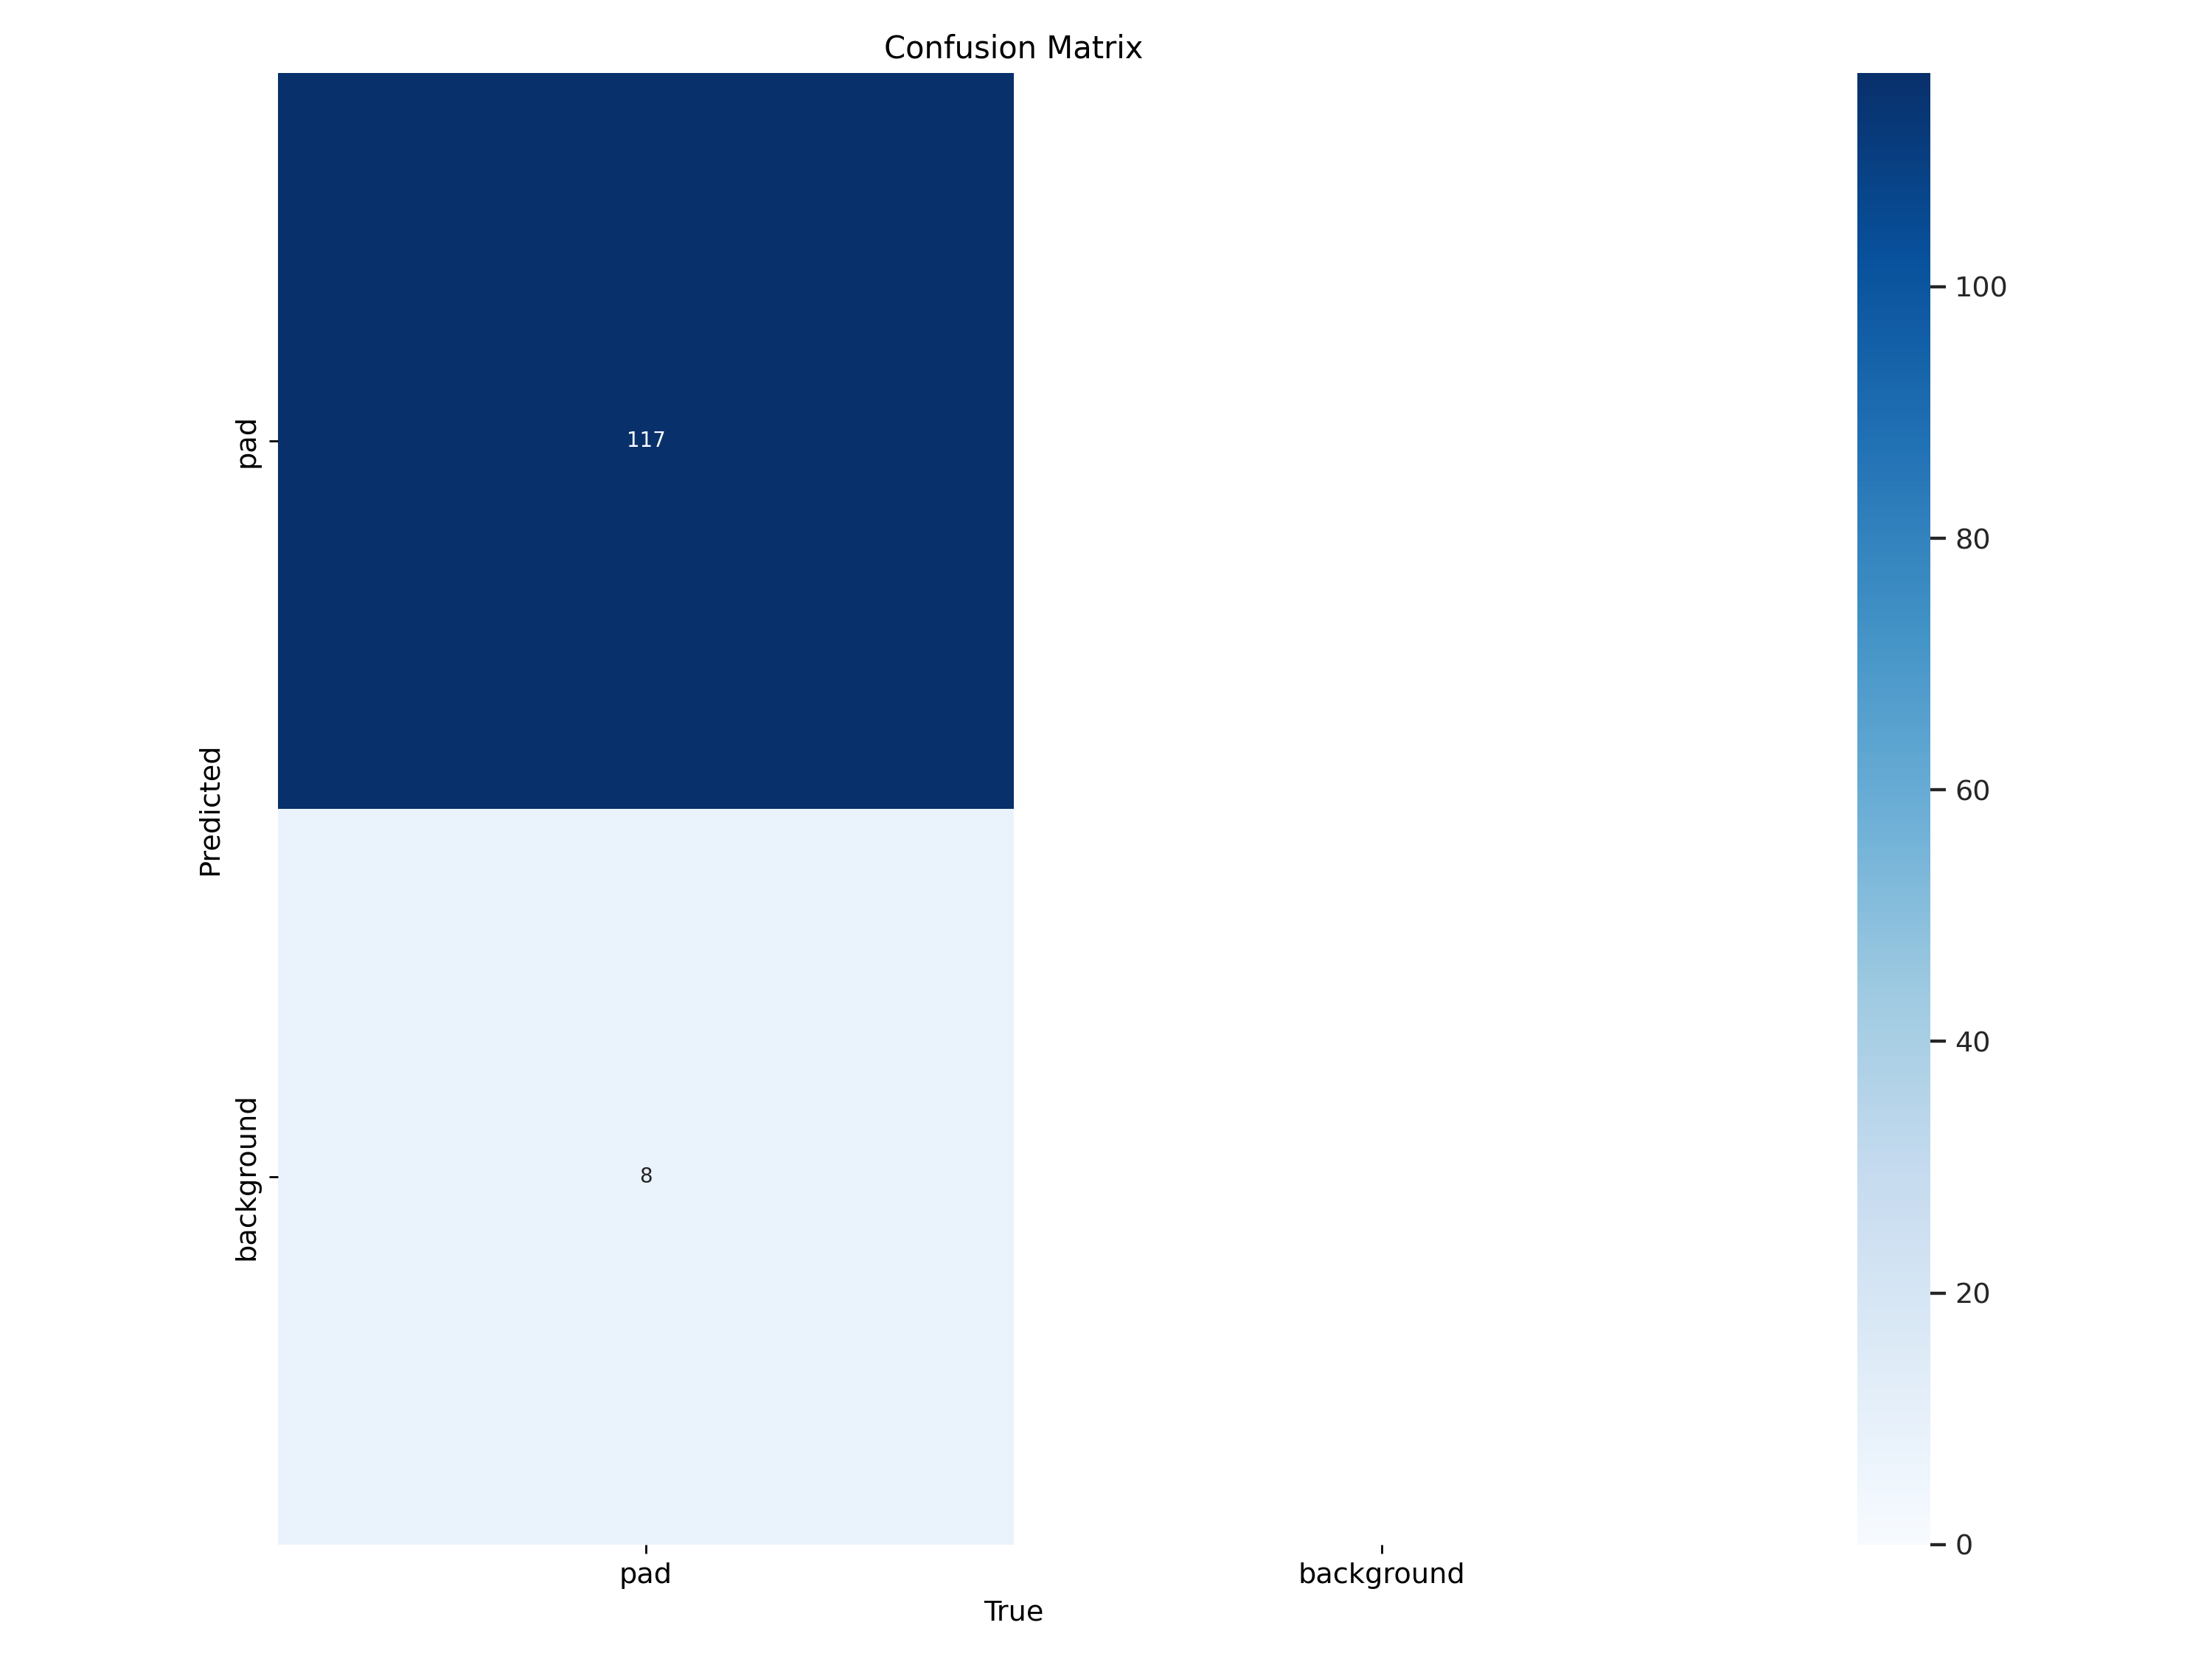

In [14]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/segment/train/confusion_matrix.png', width=500)

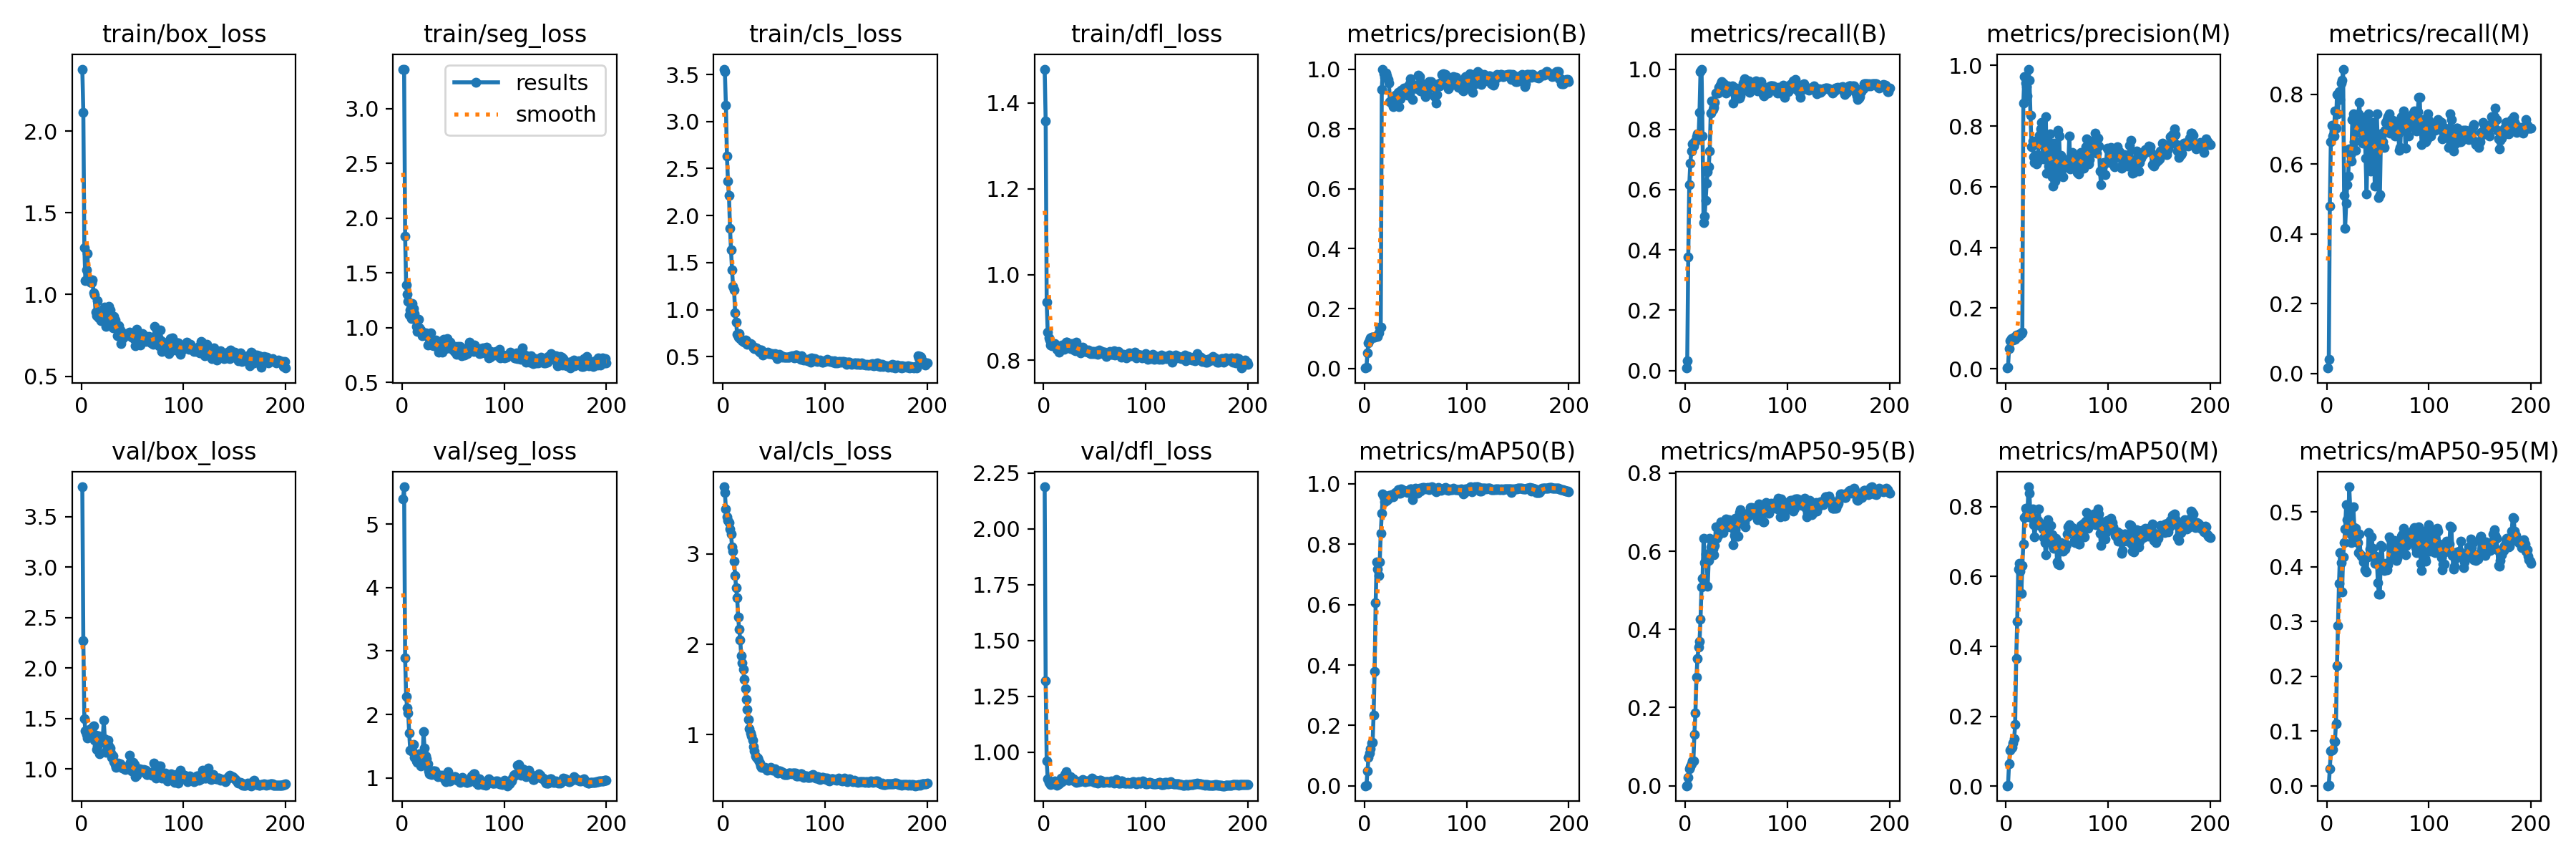

In [16]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/segment/train/results.png', width=1000)

In [17]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['pad']

In [19]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/segment/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [21]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.7071878878171218
mAP 50 0.9999999999999999
mAP 75 0.7127179454498371


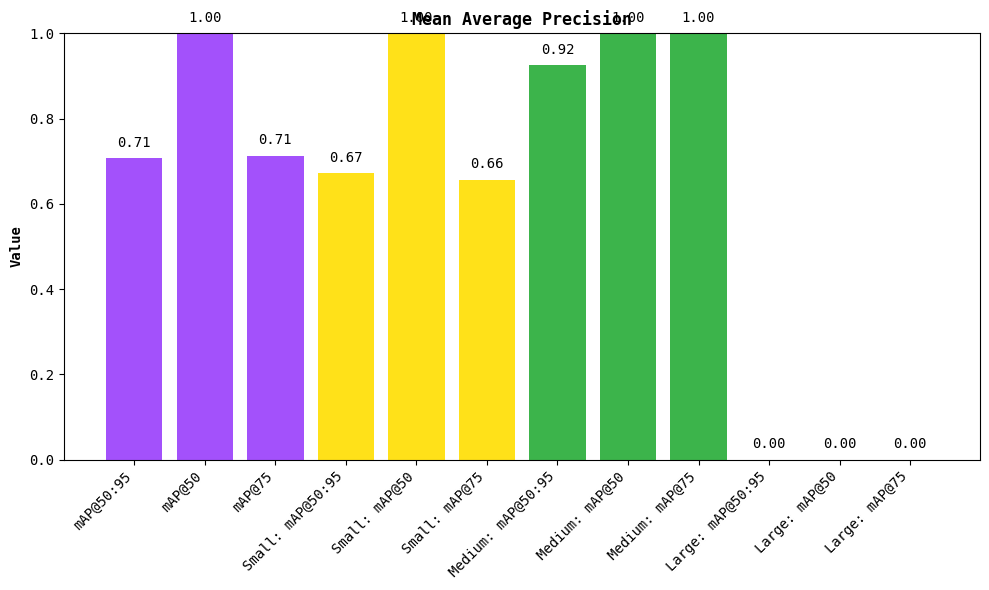

In [20]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [23]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/segment/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

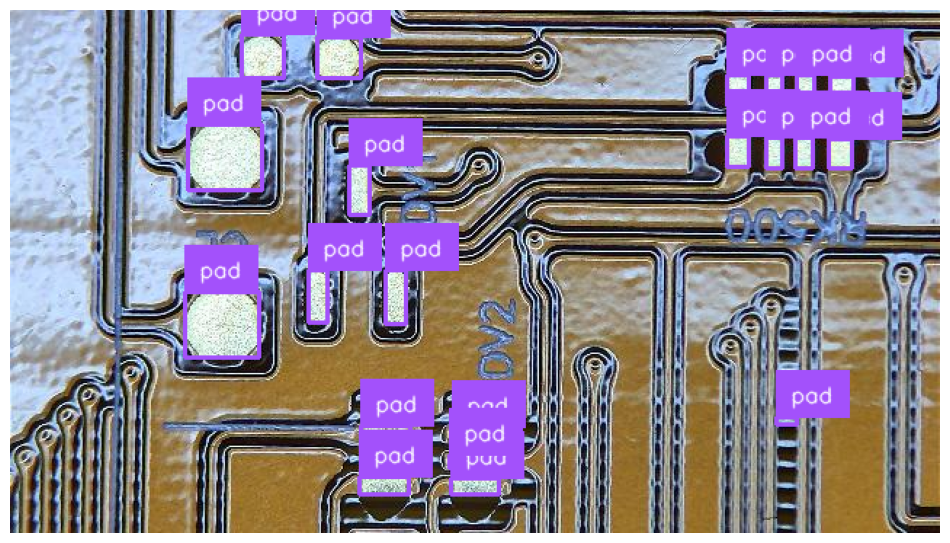

In [24]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i-1]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)